In [253]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,LabelEncoder
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D

In [254]:
csv_path="Mall_Customers - Mall_Customers.csv"
df=pd.read_csv(csv_path)
df.drop("CustomerID",axis=1,inplace=True)

In [255]:
df.columns

Index(['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')

In [256]:
df.dtypes

Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [257]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


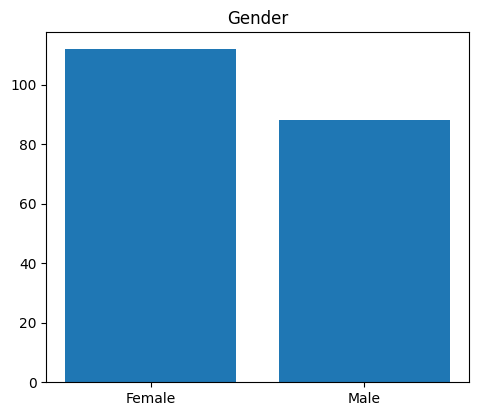

In [258]:
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.bar(df['Gender'].value_counts().keys(),df['Gender'].value_counts().values)
plt.title("Gender")    
    
plt.show()

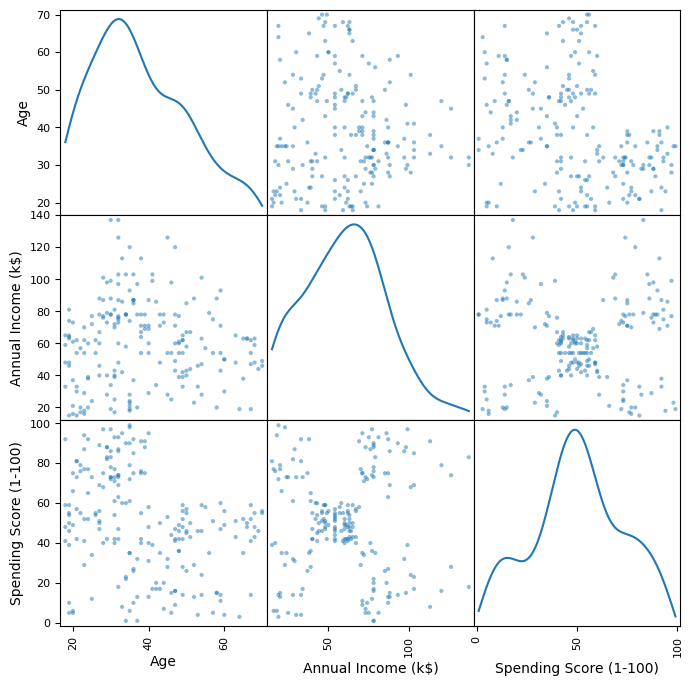

In [ ]:
pd.plotting.scatter_matrix(df, figsize=(8,8), diagonal='kde')
plt.show()

In [260]:
le=LabelEncoder()
df['Gender']=le.fit_transform(df['Gender'])

In [261]:
std_scaler=StandardScaler()

df=std_scaler.fit_transform(df)

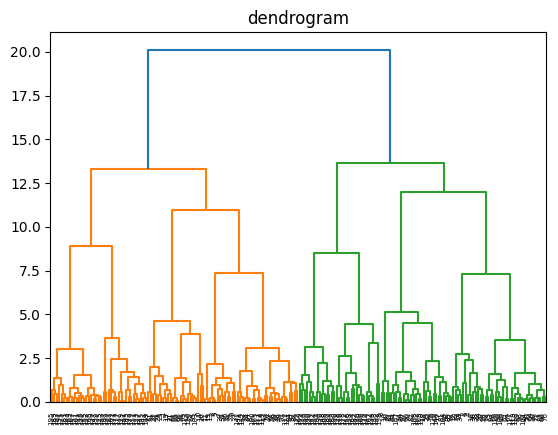

In [262]:
Z = linkage(df, method='ward') 
dendrogram(Z)
plt.title("dendrogram")
plt.show()

In [263]:
class KMeansClustering:
    def __init__(self,k:int,distance:str,init:str,X:np.array):
        self.k=k
        self.X=X
        
        distanceMetrics={'manhantan':KMeansClustering.manhantanDistance,'eculidean':KMeansClustering.eculideanDistance}
        inits={'random':self.randomCentroidIntialisation,'KMeans++':self.KplusplusIntialisation}
        
        if distance not in distanceMetrics:
            raise ValueError(f'invalid value of distance metric , the supported ones are: {[val for val in distanceMetrics]}')
        
        if init not in inits:
            raise ValueError(f'invalid initialisation method, the supported ones are: {[val for val in inits]}')
        
        self.init=inits[init]
        self.distance=distanceMetrics[distance]
    
    @staticmethod
    def eculideanDistance(x:np.array,y:np.array):
        '''
        x and y are 2-D array of shape (n1,dim) and (n2,dim) respectively
        '''
        x=np.expand_dims(x,axis=0)
        y=np.expand_dims(y,axis=1)
        return np.sum((x-y)**2,axis=2)
    
    @staticmethod
    def manhantanDistance(x:np.array,y:np.array):
        '''
        x and y are 2-D array of shape (n1,dim) and (n2,dim) respectively
        '''
        x=np.expand_dims(x,axis=0)
        y=np.expand_dims(y,axis=1)
        return np.sum(np.abs(x,y),axis=2)
    
    def randomCentroidIntialisation(self,random_state:int):
        np.random.seed(random_state)
        
        centroidIdx = np.random.choice(range(self.X.shape[0]), size=self.k, replace=False)
        self.centroids=self.X[centroidIdx]
        
        print("centroids intialised randomly !!")
        print(self.centroids.shape)
        
    def KplusplusIntialisation(self,random_state:int):
        np.random.seed(random_state)
        
        centroidIdx=[]
        idx1=np.random.choice(range(self.X.shape[0]),size=1,replace=False)
        centroidIdx.append(idx1.item())
        
        self.centroids=self.X[centroidIdx]
        
        for _ in range(1,self.k):
            dist=self.assignCluster(self.X,True)
            dist/=np.sum(dist)
            idx=np.random.choice(range(self.X.shape[0]),size=1,replace=False,p=dist)
            centroidIdx.append(idx.item())
            self.centroids=self.X[centroidIdx]
        
        print("centroids intialised using K-Means++")
        print(self.centroids.shape)
        print(centroidIdx)

    def assignCluster(self,x:np.array,dist=False):
        
        distances=self.distance(x,self.centroids)
        
        if dist:
            return np.min(distances,axis=0)
        else:
            return np.argmin(distances,axis=0)
    
    def updateCentroid(self,clusterAssigned:np.array):
        
        updated=False
        for i in range(self.k):
            mask=clusterAssigned==i
            newCentroid=np.mean(self.X[mask],axis=0)
            
            if (newCentroid!=self.centroids[i]).all():
                updated=True
                self.centroids[i]=newCentroid
        
        return updated    
    
    def optimiseCentroids(self,random_seed:int):
        
        self.init(random_seed)
        
        iter=0
        while True:
            assignedClusters=self.assignCluster(self.X)
            if not self.updateCentroid(assignedClusters):
                print("number of iterations: ",iter)
                break
            iter+=1
 

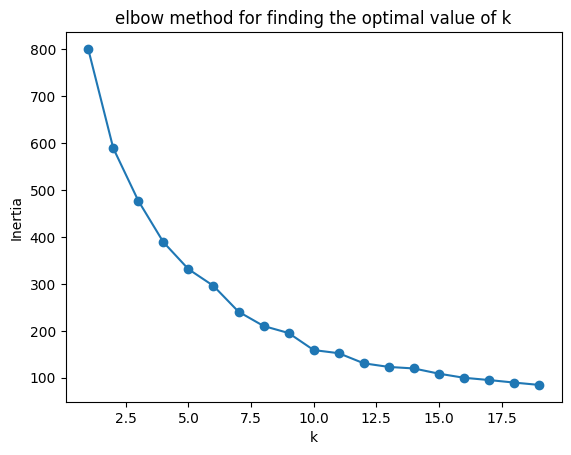

In [264]:
inertias = []
K = range(1, 20)
for k in K:
    km = KMeans(n_clusters=k, random_state=0).fit(df)
    inertias.append(km.inertia_)

plt.plot(K, inertias, marker='o')
plt.title("elbow method for finding the optimal value of k")
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

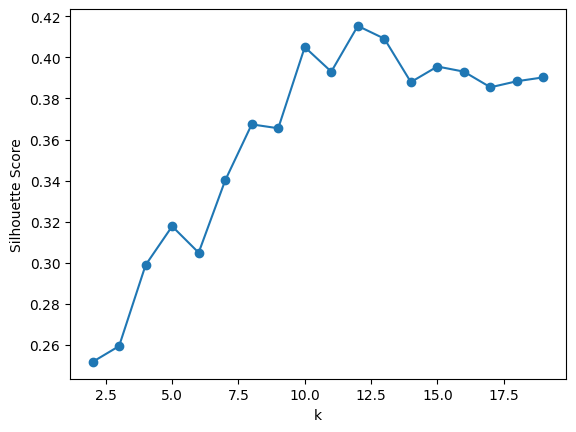

In [265]:
scores = []
for k in range(2, 20):
    km = KMeans(n_clusters=k, random_state=0).fit(df)
    score = silhouette_score(df, km.labels_)
    scores.append(score)

plt.plot(range(2, 20), scores, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.show()

### Both silhoutte score and elbow method point towards 10 being the ideal number of clusters

In [266]:
K=10
distance="eculidean"
init="KMeans++"
seed=21
clustering=KMeansClustering(K,distance,init,df)

clustering.optimiseCentroids(seed)

centroids intialised using K-Means++
(10, 4)
[144, 157, 31, 121, 51, 76, 130, 185, 64, 85]
number of iterations:  4


In [267]:
clusteringSklearn=KMeans(K).fit(df)


In [268]:
clusteringSklearn.cluster_centers_

array([[ 1.12815215,  0.38305471,  1.02351324, -1.34468181],
       [-0.88640526,  0.84174773, -0.49045708, -0.36737456],
       [-0.88640526, -0.45245636,  0.94327069,  1.17982252],
       [ 1.12815215, -0.98092016, -1.30872563,  0.86748542],
       [ 1.12815215, -0.39989994,  1.01344075,  1.26040667],
       [ 1.12815215,  1.51786549, -0.21434255, -0.02070483],
       [-0.88640526, -0.93017604, -0.73599142,  0.30065142],
       [-0.88640526,  0.33820053,  1.17380537, -1.06565184],
       [ 1.12815215, -1.09713327,  0.03110808, -0.34502662],
       [ 1.12815215,  0.90386159, -1.25127871, -1.17672464]])

In [269]:
clusteringSklearn.n_iter_

5

In [270]:
clustering.centroids

array([[ 1.12815215, -0.99396865,  0.62750542, -1.48298362],
       [-0.88640526, -0.47793198,  0.97284787,  1.22158511],
       [-0.88640526, -0.91757185, -0.88326522,  0.42803901],
       [-0.88640526,  0.07227931,  0.93104326, -0.88771969],
       [ 1.12815215, -0.41983513, -0.70842461,  0.38045129],
       [-0.88640526,  0.86598472, -0.48364908, -0.24069368],
       [ 1.12815215,  0.58489852,  0.39848884, -1.5994483 ],
       [ 1.12815215, -0.6351352 ,  1.46723286,  1.81684904],
       [ 1.12815215,  1.73316556, -0.47940803,  0.03105725],
       [ 1.12815215,  0.65666521, -0.25039146, -0.16305055]])

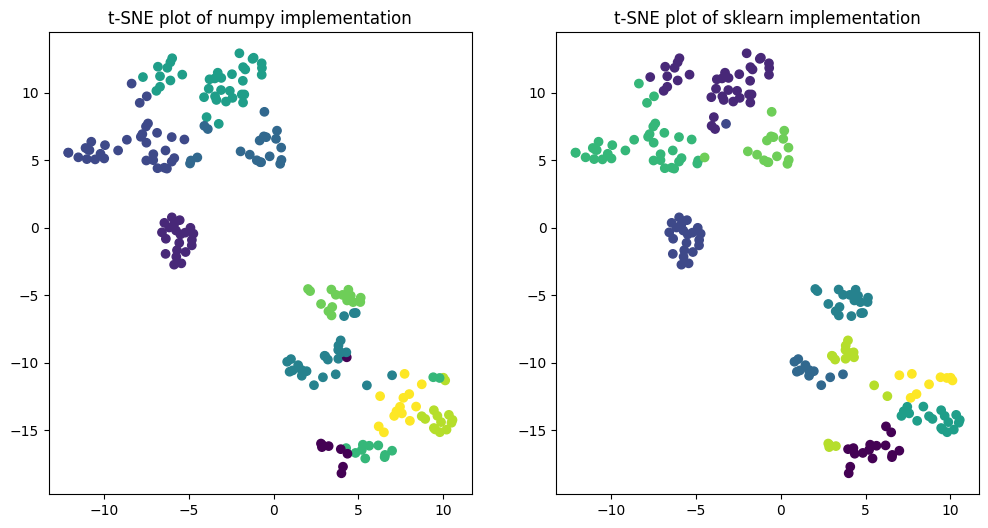

In [271]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(df)   

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=clustering.assignCluster(clustering.X), cmap='viridis')
plt.title("t-SNE plot of numpy implementation")

plt.subplot(1,2,2)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=clusteringSklearn.labels_, cmap='viridis')
plt.title("t-SNE plot of sklearn implementation")
plt.show()

In [272]:
clustered_df=pd.DataFrame(df,columns=['Gender','Age','Annual Income','Spending Score'])
clustered_df['cluster_label']=clustering.assignCluster(clustering.X)

grouped_dfs=clustered_df.groupby('cluster_label')

for label,df in grouped_dfs:
    print("cluster KNN:",label)
    print(df.drop('cluster_label',axis=1).describe())
    

cluster KNN: 0
         Gender       Age  Annual Income  Spending Score
count  9.000000  9.000000       9.000000        9.000000
mean   1.128152 -0.906254       0.992236       -1.474357
std    0.000000  0.536786       0.909304        0.459252
min    1.128152 -1.496335      -0.059544       -1.910021
25%    1.128152 -1.424569       0.512997       -1.754735
50%    1.128152 -0.993969       0.665675       -1.560627
75%    1.128152 -0.419835       1.009200       -1.482984
max    1.128152 -0.204535       2.917671       -0.357158
cluster KNN: 1
          Gender        Age  Annual Income  Spending Score
count  21.000000  21.000000      21.000000       21.000000
mean   -0.886405  -0.477932       0.972848        1.221585
std     0.000000   0.220756       0.540401        0.304033
min    -0.886405  -0.850435       0.360319        0.729845
25%    -0.886405  -0.635135       0.627505        0.962775
50%    -0.886405  -0.491602       0.703844        1.273347
75%    -0.886405  -0.276302       1.390894  

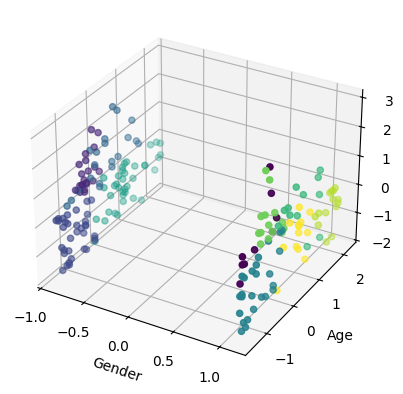

In [273]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(clustering.X[:,0], clustering.X[:,1], clustering.X[:,2], c=clustering.assignCluster(clustering.X), cmap='viridis')
ax.set_xlabel('Gender')
ax.set_ylabel('Age')
ax.set_zlabel('Annual Income')
plt.show()